In [27]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from causalnex.discretiser import Discretiser
from causalnex.structure import DAGRegressor
from causalnex.inference import InferenceEngine
from causalnex.network import BayesianNetwork
from causalnex.network.sklearn import BayesianNetworkClassifier
from causalnex.structure.notears import from_pandas
from causalnex.utils.network_utils import get_markov_blanket
from causalnex.structure.notears import from_pandas, from_pandas_lasso
from causalnex.discretiser.discretiser_strategy import ( DecisionTreeSupervisedDiscretiserMethod )

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score

ModuleNotFoundError: No module named 'causalnex'

In [13]:
sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)

In [15]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from file_handler import FileHandler
import vis_seaborn as vs
# from df_overview import DfOverview
from ScalerNormalizer import ScalerNormalizer

In [16]:
fh = FileHandler()
df = fh.read_csv("../data/data.csv")
df.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.00,0.12,0.23,0.28,0.15,0.24,0.08,0.85,0.91,5.98,86.20,0.01,0.05,0.05,0.02,0.03,0.01,25.38,17.33,184.60,1937.05,0.16,0.63,0.71,0.27,0.42,0.12,NaN
1,842517,M,20.57,17.77,132.90,1326.00,0.08,0.08,0.09,0.07,0.18,0.06,0.54,0.73,3.40,74.08,0.01,0.01,0.02,0.01,0.01,0.00,24.99,23.41,158.80,1937.05,0.12,0.19,0.24,0.19,0.28,0.09,NaN
2,84300903,M,19.69,21.25,130.00,1203.00,0.11,0.16,0.20,0.13,0.21,0.06,0.75,0.79,4.58,86.20,0.01,0.04,0.04,0.02,0.02,0.00,23.57,25.53,152.50,1709.00,0.14,0.42,0.45,0.24,0.36,0.09,NaN
3,84348301,M,11.42,20.38,77.58,386.10,0.13,0.23,0.24,0.11,0.25,0.08,0.50,1.16,3.44,27.23,0.01,0.06,0.06,0.02,0.04,0.01,14.91,26.50,98.87,567.70,0.19,0.63,0.69,0.26,0.42,0.12,NaN
4,84358402,M,20.29,14.34,135.10,1297.00,0.10,0.13,0.20,0.10,0.18,0.06,0.76,0.78,5.44,86.20,0.01,0.02,0.06,0.02,0.02,0.01,22.54,16.67,152.20,1575.00,0.14,0.20,0.40,0.16,0.24,0.08,NaN


In [22]:
feat = ['diagnosis', 'perimeter_worst', 'area_worst', 'radius_worst', 'concave points_worst', 'concave points_mean', 'perimeter_mean', 'area_mean', 'radius_mean']
x = df[feat[:9]]

In [23]:
x['diagnosis'] = x['diagnosis'].apply(lambda x: 1 if x == "M" else 0)
x.head(5)

,diagnosis,perimeter_worst,area_worst,radius_worst,concave points_worst,concave points_mean,perimeter_mean,area_mean,radius_mean
0,1,184.60,1937.05,25.38,0.27,0.15,122.80,1001.00,17.99
1,1,158.80,1937.05,24.99,0.19,0.07,132.90,1326.00,20.57
2,1,152.50,1709.00,23.57,0.24,0.13,130.00,1203.00,19.69
3,1,98.87,567.70,14.91,0.26,0.11,77.58,386.10,11.42
4,1,152.20,1575.00,22.54,0.16,0.10,135.10,1297.00,20.29


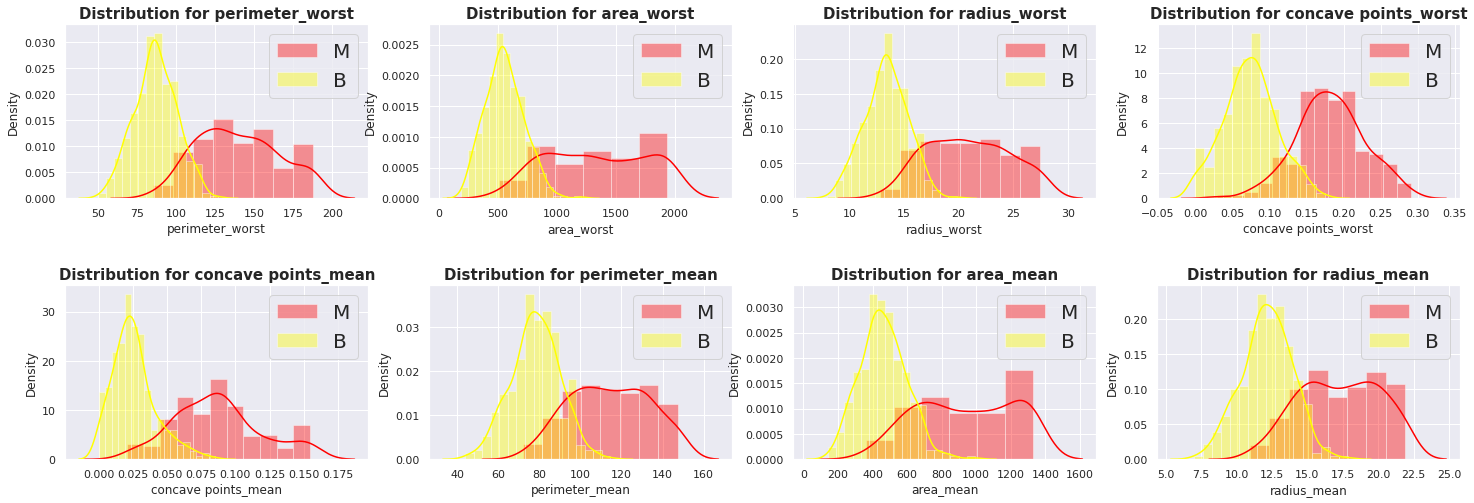

In [25]:
num_feat = x.shape[1]-1
fig = plt.figure(figsize=(25, num_feat))
fig.subplots_adjust(hspace=.5)
axs = [fig.add_subplot(num_feat / 4, 4, i + 1) for i in range(num_feat)]

for i, column in enumerate(x.columns[1:]):
    sns.distplot(x[x.diagnosis == 1][column], ax=axs[i], color='red', label="M")
    sns.distplot(x[x.diagnosis == 0][column], ax=axs[i], color='yellow', label="B")
    axs[i].set_title('Distribution for {}'.format( column), fontweight='bold', fontsize=15)
    axs[i].legend(fontsize=20)
plt.show()